Delta Hedging

Hedging a ATM call C with a time to maturity of T = 45 days. Stable T to work with.

Considering an Original Portfolio OP and a Replicating Porfolio RE. We have a long call C position in the OP and a short position delta 𝛥 = 𝜕𝐶/𝜕𝑆, of the underlying S. The initial values of OP and RE are C_0 and -𝛥_0 * S_0, respectively. 

First some imports

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

Then some function definitions for European call option prices, delta, and IV.

In [47]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [48]:
def black_scholes_delta(S, K, T, r, sigma):
    """Calculate the Black-Scholes delta of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

In [49]:
def implied_volatility(C_market, S, K, T, r, initial_guess=0.2):
    """Calculate the implied volatility using the Newton-Raphson method."""
    sigma = initial_guess
    for _ in range(100):
        C_model = black_scholes_call(S, K, T, r, sigma)
        vega = S * norm.pdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) * np.sqrt(T)
        sigma -= (C_model - C_market) / vega
        if abs(C_model - C_market) < 1e-6:
            break
    return sigma

Now the data collection,

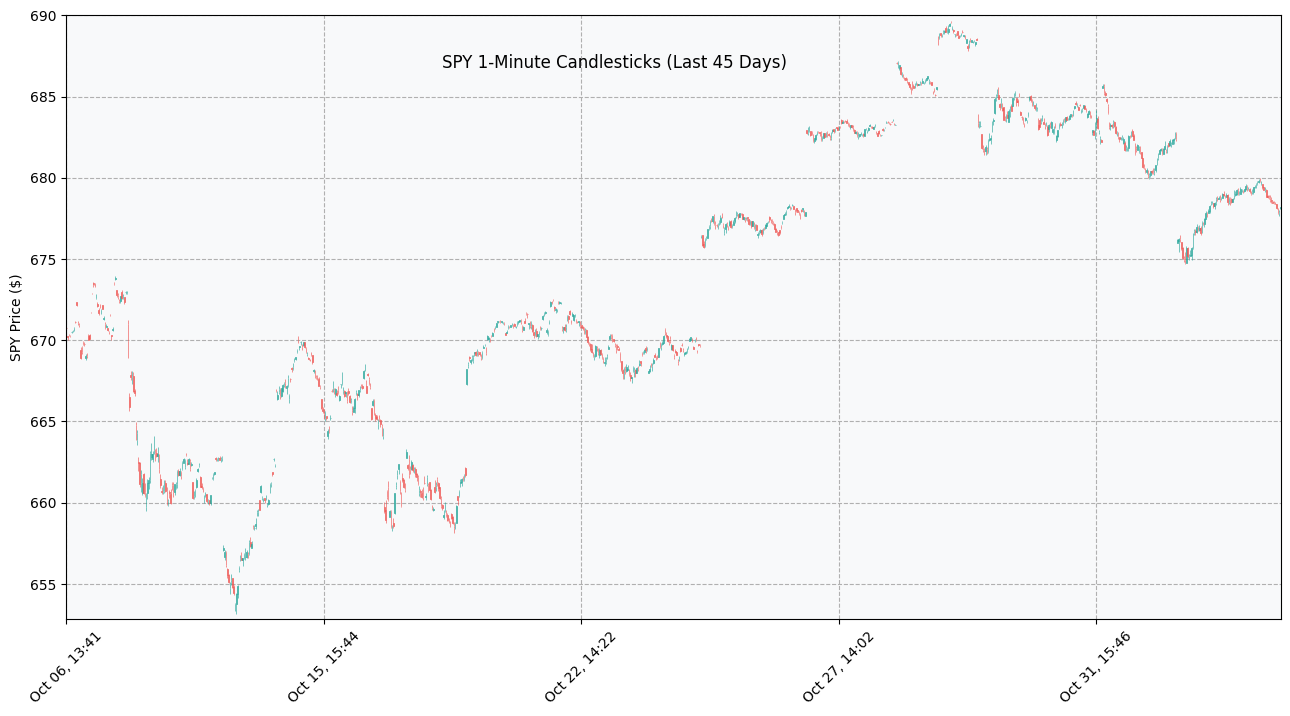

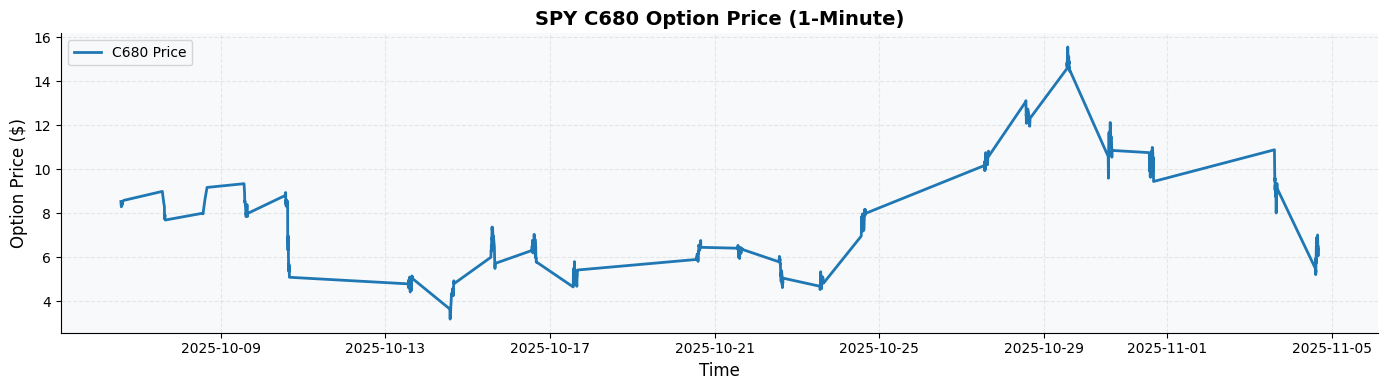

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import warnings

warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_feather("spy_1min_candles_and_call.feather")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp").sort_index()

# Rename columns for mplfinance
rename_map = {"OPEN": "Open", "HIGH": "High", "LOW": "Low", "CLOSE": "Close"}
df = df.rename(columns=rename_map)

spy_df = df[["Open", "High", "Low", "Close"]]
opt_df = df[["C680"]] if "C680" in df.columns else None

# === Candlestick Chart with modern colors ===
mc = mpf.make_marketcolors(
    up="#26a69a", down="#ef5350", edge="i", wick="i", volume="in"
)
s  = mpf.make_mpf_style(marketcolors=mc, gridstyle="--", facecolor="#f8f9fa")

mpf.plot(
    spy_df,
    type="candle",
    style=s,
    title="SPY 1-Minute Candlesticks (Last 45 Days)",
    ylabel="SPY Price ($)",
    figsize=(14, 7),
    tight_layout=True,
    figratio=(16, 9),
)

# === Option price line plot with nicer styling ===
if opt_df is not None:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(opt_df.index, opt_df["C680"], color="#1f77b4", lw=2, label="C680 Price")
    ax.set_title("SPY C680 Option Price (1-Minute)", fontsize=14, weight="bold")
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Option Price ($)", fontsize=12)
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No option data (C680) found.")

Delta hedging simulation,

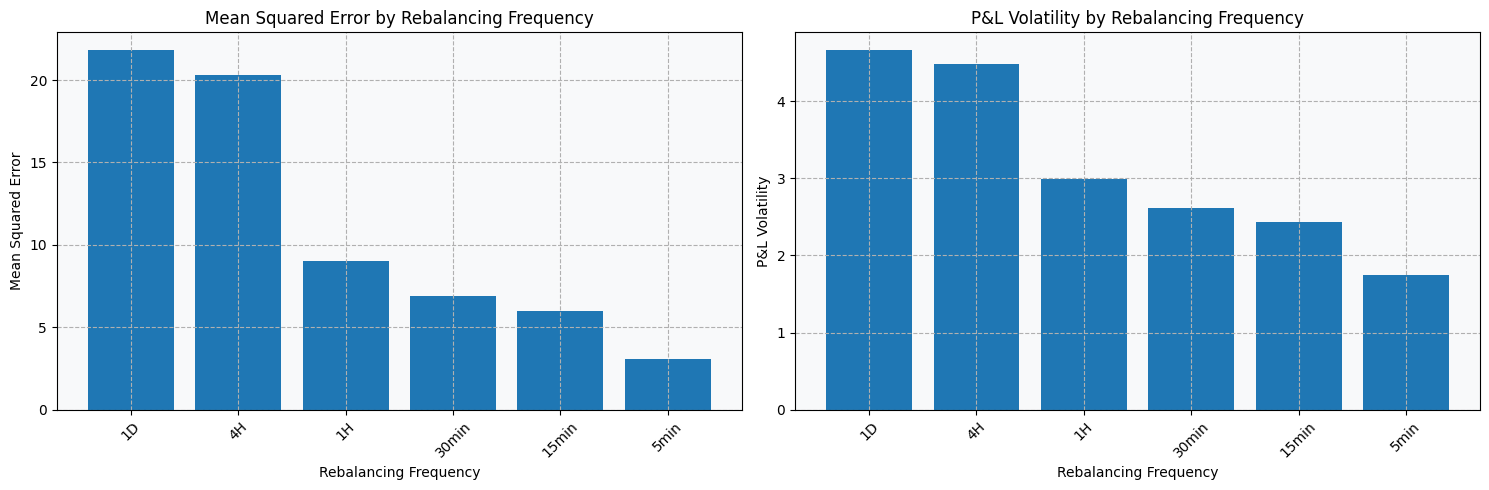


Hedging Performance by Rebalancing Frequency:
--------------------------------------------------

Frequency: 1D
Mean Squared Error: 21.800764
Final P&L: $3.71
P&L Volatility: $4.66

Frequency: 4H
Mean Squared Error: 20.280181
Final P&L: $5.59
P&L Volatility: $4.48

Frequency: 1H
Mean Squared Error: 9.029405
Final P&L: $5.99
P&L Volatility: $2.99

Frequency: 30min
Mean Squared Error: 6.887228
Final P&L: $6.18
P&L Volatility: $2.61

Frequency: 15min
Mean Squared Error: 5.982706
Final P&L: $5.98
P&L Volatility: $2.44

Frequency: 5min
Mean Squared Error: 3.065422
Final P&L: $6.08
P&L Volatility: $1.75


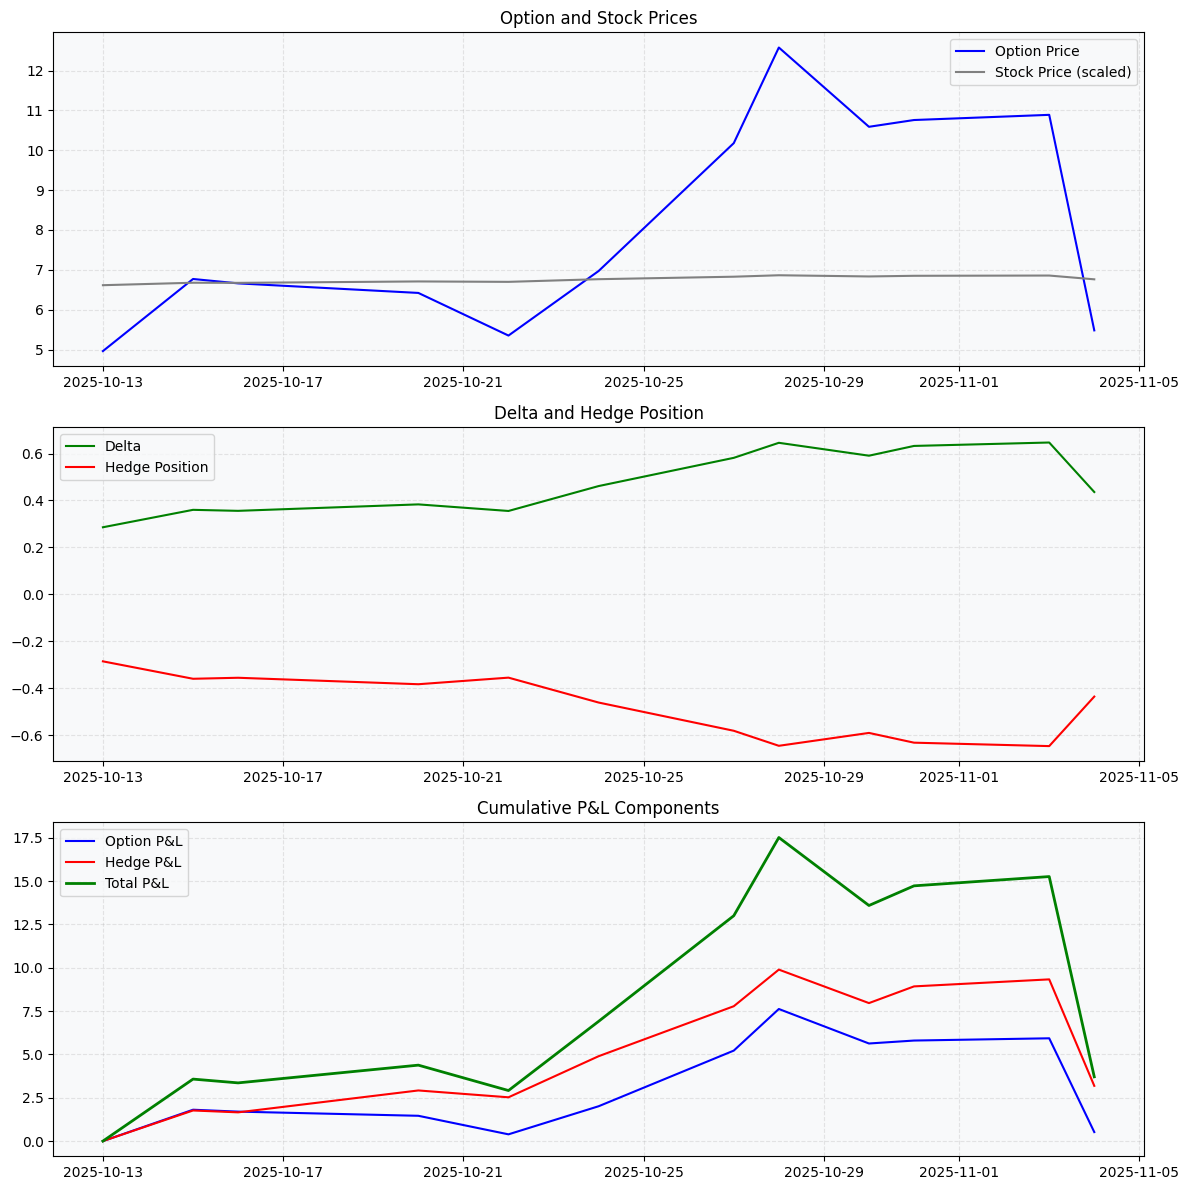


Hedging Summary:
Final P&L: $3.71
Option P&L: $0.52
Hedge P&L: $3.19
Mean Daily P&L: $0.31
P&L Volatility: $4.66


In [124]:
def run_delta_hedge(df, rebalance_freq='1D'):
    """
    Simple delta hedging simulation with P&L tracking
    
    Parameters:
    df: DataFrame with stock and option data
    rebalance_freq: Rebalancing frequency ('1D' for daily, '1H' for hourly)
    """
    # Resample data to desired frequency
    hedge_times = df.resample(rebalance_freq).first().dropna()
    
    # Initialize results storage
    results = pd.DataFrame(index=hedge_times.index)
    results['Stock_Price'] = hedge_times['Close']
    results['Option_Price'] = hedge_times['C680']
    
    # Parameters
    K = 680  # Strike price
    r = 0.02  # Risk-free rate
    
    # Initialize tracking columns
    results['T'] = (45 - (results.index - results.index[0]).days) / 365
    results['Delta'] = 0.0
    results['Hedge_Position'] = 0.0
    results['Option_PnL'] = 0.0
    results['Hedge_PnL'] = 0.0
    results['Total_PnL'] = 0.0
    results['Cumulative_PnL'] = 0.0
    
    # Calculate hedging positions and P&L
    for i in range(len(results)):
        try:
            S = results['Stock_Price'].iloc[i]
            C = results['Option_Price'].iloc[i]
            T = results['T'].iloc[i]
            
            # Skip if option is expired
            if T <= 0:
                continue
                
            # Get implied vol and delta
            sigma = implied_volatility(C, S, K, T, r)
            delta = black_scholes_delta(S, K, T, r, sigma)
            
            # Store delta and hedge position
            results.loc[results.index[i], 'Delta'] = delta
            results.loc[results.index[i], 'Hedge_Position'] = -delta
            
            # Calculate P&L if not first observation
            if i > 0:
                dS = S - results['Stock_Price'].iloc[i-1]
                dC = C - results['Option_Price'].iloc[i-1]
                prev_delta = results['Delta'].iloc[i-1]
                
                # Calculate P&L components
                option_pnl = dC
                hedge_pnl = prev_delta * dS
                total_pnl = option_pnl + hedge_pnl
                
                results.loc[results.index[i], 'Option_PnL'] = option_pnl
                results.loc[results.index[i], 'Hedge_PnL'] = hedge_pnl
                results.loc[results.index[i], 'Total_PnL'] = total_pnl
                
        except:
            print(f"Calculation failed at {results.index[i]}")
            continue
    
    # Calculate cumulative P&L
    results['Cumulative_PnL'] = results['Total_PnL'].cumsum()
    
    return results

# Add after the run_delta_hedge function

def calculate_hedge_error(results):
    """
    Calculate mean squared hedging error as specified in the assignment
    E = 1/(n-1) * sum(A²) where A is the hedging error
    """
    A = results['Total_PnL']  # Hedging error at each step
    n = len(A)
    if n <= 1:
        return np.nan
    E = (A**2).sum() / (n-1)  # Mean squared error
    return E

# Test different rebalancing frequencies
frequencies = ['1D', '4H', '1H', '30min', '15min', '5min']
frequency_results = {}

for freq in frequencies:
    results = run_delta_hedge(df, rebalance_freq=freq)
    frequency_results[freq] = {
        'MSE': calculate_hedge_error(results),
        'Final_PnL': results['Cumulative_PnL'].iloc[-1],
        'PnL_Volatility': results['Total_PnL'].std()
    }

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Mean Squared Error
mse_values = [frequency_results[freq]['MSE'] for freq in frequencies]
ax1.bar(frequencies, mse_values)
ax1.set_title('Mean Squared Error by Rebalancing Frequency')
ax1.set_xlabel('Rebalancing Frequency')
ax1.set_ylabel('Mean Squared Error')
ax1.tick_params(axis='x', rotation=45)

# Plot P&L Volatility
vol_values = [frequency_results[freq]['PnL_Volatility'] for freq in frequencies]
ax2.bar(frequencies, vol_values)
ax2.set_title('P&L Volatility by Rebalancing Frequency')
ax2.set_xlabel('Rebalancing Frequency')
ax2.set_ylabel('P&L Volatility')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nHedging Performance by Rebalancing Frequency:")
print("-" * 50)
for freq in frequencies:
    print(f"\nFrequency: {freq}")
    print(f"Mean Squared Error: {frequency_results[freq]['MSE']:.6f}")
    print(f"Final P&L: ${frequency_results[freq]['Final_PnL']:.2f}")
    print(f"P&L Volatility: ${frequency_results[freq]['PnL_Volatility']:.2f}")

# Run simulation with daily rebalancing
results = run_delta_hedge(df, rebalance_freq='1D')

# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot 1: Prices
ax1.plot(results.index, results['Option_Price'], label='Option Price', color='blue')
ax1.plot(results.index, results['Stock_Price']/100, label='Stock Price (scaled)', color='gray')
ax1.set_title('Option and Stock Prices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Delta and Hedge Position
ax2.plot(results.index, results['Delta'], label='Delta', color='green')
ax2.plot(results.index, results['Hedge_Position'], label='Hedge Position', color='red')
ax2.set_title('Delta and Hedge Position')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: P&L Components
ax3.plot(results.index, results['Option_PnL'].cumsum(), label='Option P&L', color='blue')
ax3.plot(results.index, results['Hedge_PnL'].cumsum(), label='Hedge P&L', color='red')
ax3.plot(results.index, results['Cumulative_PnL'], label='Total P&L', color='green', linewidth=2)
ax3.set_title('Cumulative P&L Components')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHedging Summary:")
print(f"Final P&L: ${results['Cumulative_PnL'].iloc[-1]:.2f}")
print(f"Option P&L: ${results['Option_PnL'].sum():.2f}")
print(f"Hedge P&L: ${results['Hedge_PnL'].sum():.2f}")
print(f"Mean Daily P&L: ${results['Total_PnL'].mean():.2f}")
print(f"P&L Volatility: ${results['Total_PnL'].std():.2f}")